In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import re
import os
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

In [2]:
# Define paths
DATASET_PATH = '/content/drive/MyDrive/big_data_datasets/passwords_dataset.csv'
MODEL_SAVE_PATH = '/content/drive/MyDrive/big_data_datasets/best_models'
PLOT_SAVE_PATH = '/content/drive/MyDrive/big_data_datasets/model_comparison.png'

In [ ]:
# Create model save directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [ ]:
# 1. Load and Clean Data
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna(subset=['Password', 'Strength'])
    df = df[df['Password'] != '#NAME?']
    df['Strength'] = df['Strength'].astype(int)
    valid_strengths = [0, 1, 2]
    df = df[df['Strength'].isin(valid_strengths)]
    return df

In [3]:
# 2. Feature Engineering
def extract_features(password):
    features = {}
    features['length'] = len(password)
    features['has_letters'] = int(bool(re.search(r'[a-zA-Z]', password)))
    features['has_numbers'] = int(bool(re.search(r'\d', password)))
    features['has_special'] = int(bool(re.search(r'[^a-zA-Z\d]', password)))
    features['unique_chars'] = len(set(password)) / max(1, len(password))
    features['uppercase_count'] = sum(1 for c in password if c.isupper())
    features['lowercase_count'] = sum(1 for c in password if c.islower())
    features['number_count'] = sum(1 for c in password if c.isdigit())
    features['special_count'] = sum(1 for c in password if not c.isalnum())
    return features

In [ ]:
# 3. Prepare Data
def prepare_data(df):
    features = df['Password'].apply(extract_features)
    feature_df = pd.DataFrame(features.tolist())
    X = feature_df.values
    y = df['Strength'].values
    return X, y, feature_df.columns

In [ ]:
# 4. Train and Evaluate Model with RandomizedSearchCV
def train_and_evaluate_model(model, param_dist, X_train, X_test, y_train, y_test, model_name):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='accuracy',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n{model_name} Evaluation:")
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Weak (0)', 'Medium (1)', 'Strong (2)']))

    model_path = os.path.join(MODEL_SAVE_PATH, f"best_{model_name.lower().replace(' ', '_')}.pkl")
    joblib.dump(best_model, model_path)
    print(f"Best {model_name} saved to {model_path}")

    return best_model, {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# 5. Predict Strength for New Password
def predict_password_strength(model, password, feature_columns):
    features = extract_features(password)
    feature_array = np.array([features[col] for col in feature_columns]).reshape(1, -1)
    prediction = model.predict(feature_array)[0]
    probability = model.predict_proba(feature_array)[0] if hasattr(model, 'predict_proba') else [None, None, None]
    strength_label = {0: 'Weak', 1: 'Medium', 2: 'Strong'}[prediction]
    return strength_label, probability

In [ ]:
# 6. Plot Model Comparison
def plot_model_comparison(metrics_dict):
    models = list(metrics_dict.keys())
    precision = [metrics_dict[model]['precision'] for model in models]
    recall = [metrics_dict[model]['recall'] for model in models]
    f1 = [metrics_dict[model]['f1'] for model in models]

    x = np.arange(len(models))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, precision, width, label='Precision (macro)', color='#3B82F6')
    plt.bar(x, recall, width, label='Recall (macro)', color='#EF4444')
    plt.bar(x + width, f1, width, label='F1-Score (macro)', color='#10B981')

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Model Comparison: Precision, Recall, F1-Score')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.savefig(PLOT_SAVE_PATH)
    plt.close()
    print(f"Comparison plot saved to {PLOT_SAVE_PATH}")

In [ ]:
# Main Execution
if __name__ == "__main__":
    # Load and clean data
    df = load_and_clean_data(DATASET_PATH)
    print(f"Loaded {len(df)} valid passwords")

    # Prepare data
    X, y, feature_columns = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models and hyperparameter grids (as provided)
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'param_dist': {
                'n_estimators': randint(50, 200),
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': randint(2, 10)
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
            'param_dist': {
                'n_estimators': randint(50, 200),
                'max_depth': randint(3, 8),
                'learning_rate': uniform(0.01, 0.3)
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'param_dist': {
                'n_neighbors': randint(3, 10),
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },
        'Logistic Regression': {
            'model': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
            'param_dist': {
                'C': uniform(0.1, 10),
                'max_iter': [1000]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'param_dist': {
                'n_estimators': randint(50, 200),
                'learning_rate': uniform(0.01, 0.3),
                'max_depth': randint(3, 8)
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42),
            'param_dist': {
                'n_estimators': randint(50, 200),
                'learning_rate': uniform(0.01, 0.3),
                'max_depth': randint(3, 8)
            }
        }
    }

    # Train and evaluate each model, collect metrics
    best_models = {}
    metrics_dict = {}
    for model_name, config in models.items():
        print(f"\nTraining {model_name}...")
        best_model, metrics = train_and_evaluate_model(
            config['model'], config['param_dist'], X_train, X_test, y_train, y_test, model_name
        )
        best_models[model_name] = best_model
        metrics_dict[model_name] = metrics

    # Plot model comparison
    plot_model_comparison(metrics_dict)

    # Test new passwords with the best Random Forest model
    print("\nTesting new passwords with Random Forest:")
    test_passwords = ["password123", "P@ssw0rd!2023", "abc", "MySecureP@ss12"]
    for password in test_passwords:
        strength, prob = predict_password_strength(best_models['Random Forest'], password, feature_columns)
        print(f"Password: {password} -> Strength: {strength} (Probability: Weak={prob[0]:.4f}, Medium={prob[1]:.4f}, Strong={prob[2]:.4f})")

Loaded 42831 valid passwords

Training Random Forest...

Random Forest Evaluation:
Best Parameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 51}
Accuracy: 0.9950
Precision (macro): 0.9919
Recall (macro): 0.9948
F1-Score (macro): 0.9933

Classification Report:
              precision    recall  f1-score   support

    Weak (0)       1.00      1.00      1.00      3484
  Medium (1)       1.00      0.99      0.99      3828
  Strong (2)       0.98      0.99      0.99      1255

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       1.00      0.99      0.99      8567

Best Random Forest saved to /content/drive/MyDrive/big_data_datasets/best_models/best_random_forest.pkl

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation:
Best Parameters: {'learning_rate': np.float64(0.0823076398078035), 'max_depth': 6, 'n_estimators': 57}
Accuracy: 0.9950
Precision (macro): 0.9917
Recall (macro): 0.9949
F1-Score (macro): 0.9933

Classification Report:
              precision    recall  f1-score   support

    Weak (0)       1.00      1.00      1.00      3484
  Medium (1)       1.00      0.99      0.99      3828
  Strong (2)       0.98      0.99      0.99      1255

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       1.00      0.99      0.99      8567

Best XGBoost saved to /content/drive/MyDrive/big_data_datasets/best_models/best_xgboost.pkl

Training KNN...

KNN Evaluation:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'uniform'}
Accuracy: 0.9910
Precision (macro): 0.9880
Recall (macro): 0.9891
F1-Score (macro): 0.9886

Classification Report:
              precision    recall  f1-score   support

   

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Evaluation:
Best Parameters: {'C': np.float64(0.6808361216819946), 'max_iter': 1000}
Accuracy: 0.9414
Precision (macro): 0.9459
Recall (macro): 0.9509
F1-Score (macro): 0.9478

Classification Report:
              precision    recall  f1-score   support

    Weak (0)       0.97      0.91      0.94      3484
  Medium (1)       0.92      0.96      0.94      3828
  Strong (2)       0.95      0.99      0.97      1255

    accuracy                           0.94      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.94      0.94      0.94      8567

Best Logistic Regression saved to /content/drive/MyDrive/big_data_datasets/best_models/best_logistic_regression.pkl

Training Gradient Boosting...

Gradient Boosting Evaluation:
Best Parameters: {'learning_rate': np.float64(0.05680559213273095), 'max_depth': 5, 'n_estimators': 124}
Accuracy: 0.9945
Precision (macro): 0.9916
Recall (macro): 0.9935
F1-Score (macro): 0.9926

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 34264, number of used features: 9
[LightGBM] [Info] Start training from score -0.916116
[LightGBM] [Info] Start training from score -0.780817
[LightGBM] [Info] Start training from score -1.952645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Evaluation:
Best Parameters: {'learning_rate': np.float64(0.02692347370813008), 'max_depth': 6, 'n_estimators': 87}
Accuracy: 0.9949
Precision (macro): 0.9913
Recall (macro): 0.9952
F1-Score (macro): 0.9932

Classification Report:
              precision    recall  f1-score   support

    Weak (0)       1.00      1.00      1.00      3484
  Medium (1)       1.00      0.99      0.99      3828
  Strong (2)       0.98      1.00      0.99      1255

    accuracy                           0.99      8567
   macro avg       0.99      1.00      0.99      8567
weighted avg       0.99      0.99      0.99      8567

Best LightGBM saved to /content/drive/MyDrive/big_data_datasets/best_models/best_lightgbm.pkl
Comparison plot saved to /content/drive/MyDrive/big_data_datasets/model_comparison.png

Testing new passwords with Random Forest:
Password: password123 -> Strength: Medium (Probability: Weak=0.0000, Medium=1.0000, Strong=0.0000)
Password: P@ssw0rd!2023 -> Strength: Strong (Probabilit

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def create_cnn_model():
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(9, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(32, 3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def train_cnn_model(X_train, y_train, X_test, y_test, model_name="CNN"):
    # Reshape data for CNN (samples, timesteps, channels)
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Create KerasClassifier
    model = KerasClassifier(
        model=create_cnn_model,
        epochs=50,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )

    # Train model
    model.fit(X_train_cnn, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_cnn)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n{model_name} Evaluation:")
    print(f"Fixed Parameters: {{'num_filters': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 32}}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Weak (0)', 'Medium (1)', 'Strong (2)']))

    model_path = os.path.join(MODEL_SAVE_PATH, f"best_{model_name.lower()}.pkl")
    joblib.dump(model, model_path)
    print(f"Best {model_name} saved to {model_path}")

    return model, {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


In [ ]:
def predict_password_strength(model, password, feature_columns, is_cnn=False):
    features = extract_features(password)
    feature_array = np.array([features[col] for col in feature_columns]).reshape(1, -1)

    if is_cnn:
        feature_array = feature_array.reshape(1, feature_array.shape[1], 1)

    prediction = model.predict(feature_array)[0]
    probability = model.predict_proba(feature_array)[0] if hasattr(model, 'predict_proba') else [None, None, None]
    strength_label = {0: 'Weak', 1: 'Medium', 2: 'Strong'}[prediction]
    return strength_label, probability

In [ ]:
print(f"\nTraining CNN...")
best_cnn, cnn_metrics = train_cnn_model(X_train, y_train, X_test, y_test, model_name="CNN")
best_models['CNN'] = best_cnn
metrics_dict['CNN'] = cnn_metrics


Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CNN Evaluation:
Fixed Parameters: {'num_filters': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 32}
Accuracy: 0.9943
Precision (macro): 0.9900
Recall (macro): 0.9953
F1-Score (macro): 0.9926

Classification Report:
              precision    recall  f1-score   support

    Weak (0)       1.00      1.00      1.00      3484
  Medium (1)       1.00      0.99      0.99      3828
  Strong (2)       0.97      1.00      0.99      1255

    accuracy                           0.99      8567
   macro avg       0.99      1.00      0.99      8567
weighted avg       0.99      0.99      0.99      8567

Best CNN saved to /content/drive/MyDrive/big_data_datasets/best_models/best_cnn.pkl


In [ ]:
plot_model_comparison(metrics_dict)

Comparison plot saved to /content/drive/MyDrive/big_data_datasets/model_comparison.png


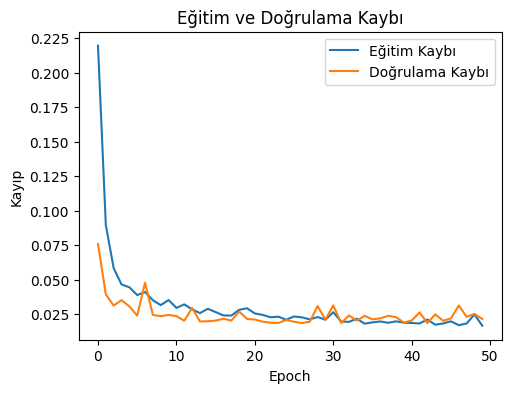

In [ ]:
# Eğitim ve doğrulama kaybı grafiği
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_cnn.history_['loss'], label='Eğitim Kaybı')
plt.plot(best_cnn.history_['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

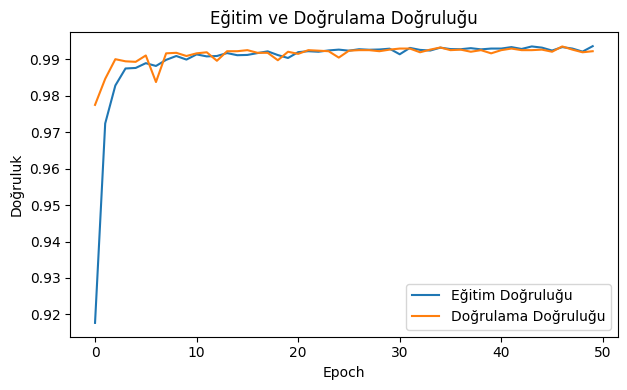

In [ ]:
# Eğitim ve doğrulama doğruluğu grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(best_cnn.history_['accuracy'], label='Eğitim Doğruluğu')
plt.plot(best_cnn.history_['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [5]:
import gradio as gr

In [6]:
def load_models(model_dir):
    models = {}
    for filename in os.listdir(model_dir):
        if filename.endswith('.pkl'):
            model_name = filename.replace('best_', '').replace('.pkl', '').replace('_', ' ').title()
            model_path = os.path.join(model_dir, filename)
            try:
                model = joblib.load(model_path)
                models[model_name] = model
            except Exception as e:
                print(f"Error loading {model_name}: {e}")
    return models

In [7]:
# Predict probabilities for a password
def predict_password_strength(password):
    if not password or len(password.strip()) == 0:
        return None, "Please enter a valid password."
    if len(password) > 100:
        return None, "Password is too long. Please use up to 100 characters."

    # Define feature columns (same as training)
    feature_columns = [
        'length', 'has_letters', 'has_numbers', 'has_special', 'unique_chars',
        'uppercase_count', 'lowercase_count', 'number_count', 'special_count'
    ]

    # Load models
    models = load_models(MODEL_SAVE_PATH)
    if not models:
        return None, "No models found in the specified directory."

    # Extract features
    features = extract_features(password)
    feature_array = np.array([features[col] for col in feature_columns]).reshape(1, -1)

    # Collect predictions
    results = []
    highest_prob = {'model': '', 'class': '', 'prob': 0}

    for model_name, model in models.items():
        is_cnn = 'Cnn' in model_name.lower()
        # Reshape for CNN to 3D (1, 9, 1), keep 2D for others
        input_data = feature_array.reshape(1, feature_array.shape[1], 1) if is_cnn else feature_array

        try:
            probs = model.predict_proba(input_data)[0]
            probs_percent = [round(p * 100, 2) for p in probs]
            results.append({
                'Model': model_name,
                'Weak (%)': probs_percent[0],
                'Medium (%)': probs_percent[1],
                'Strong (%)': probs_percent[2]
            })

            # Track highest probability
            max_prob = max(probs_percent)
            max_class = ['Weak', 'Medium', 'Strong'][probs_percent.index(max_prob)]
            if max_prob > highest_prob['prob']:
                highest_prob = {'model': model_name, 'class': max_class, 'prob': max_prob}
        except Exception as e:
            results.append({
                'Model': model_name,
                'Weak (%)': 'Error',
                'Medium (%)': 'Error',
                'Strong (%)': str(e)
            })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Highlight message
    highlight = f"**Highest Probability**: {highest_prob['model']} predicts **{highest_prob['class']}** with {highest_prob['prob']}% confidence."

    return results_df, highlight

In [9]:
# Gradio interface with Blocks
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue", secondary_hue="gray")) as demo:
    gr.Markdown(
        """
        # 🔒 Password Strength Classifier
        Enter a password below to see how strong it is, according to multiple machine learning models.
        The table on the right shows each **model's name** and the probability (%) of the password being **Weak**, **Medium**, or **Strong**.
        """
    )

    with gr.Row():
        with gr.Column(scale=2):
            password_input = gr.Textbox(
                label="Enter Your Password",
                show_label=True
            )
            submit_button = gr.Button("Classify Password", variant="primary")
        with gr.Column(scale=3):
            output_highlight = gr.Markdown(label="Prediction Highlight")
            output_table = gr.Dataframe(
                label="Model Predictions (Probabilities in %)",
                headers=["Model", "Weak (%)", "Medium (%)", "Strong (%)"],
                datatype=["str", "number", "number", "number"],
                interactive=False,
                show_label=True,
                col_count=(4, "fixed")
            )

    gr.Markdown(
        """
        ### About the Models
        Models include Random Forest, SVM, XGBoost, KNN, Logistic Regression, Gradient Boosting, LightGBM trained on a password dataset with three strength classes.
        """
    )

    # Bind the submit button
    submit_button.click(
        fn=predict_password_strength,
        inputs=password_input,
        outputs=[output_table, output_highlight]
    )

# Launch the interface
demo.launch(share=True, debug=True)  # share=False for Colab; use share=True for public link if desired

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1de6fefd552518e99a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1de6fefd552518e99a.gradio.live
